# League of Legends (10-Minute Win Prediction)

## Project Overview

**Goal**: Build a machine learning model that:
1. **Predicts match outcome** (win/loss) using only game state information available at the **10-minute mark**
2. **Guides players** on how to win games by identifying what actions and priorities matter most in the first 10 minutes

**Why 10 minutes?** Early game decisions and economy advantages often set the trajectory for the rest of the match. If we can predict outcomes from just 10 minutes of data, this has practical applications for:
- **Player guidance**: Actionable insights on what to prioritize in the first 10 minutes to maximize win probability
- **Game balance analysis**: Understanding which early-game factors correlate with victory
- **Player coaching**: Identifying what to prioritize in the early game
- **Match analytics**: Real-time win probability estimation

## Dataset & Target

- **Dataset**: `high_diamond_ranked_10min.csv` (high-ranked competitive matches)
- **Target**: `blueWins` (binary: 1 = Blue team wins, 0 = Red team wins)
- **Features**: ~38 numeric features capturing economy (gold), experience (XP), objectives (dragons, towers), and combat stats (kills, deaths, assists)

## Methodology Overview

1. **EDA**: Understand data quality, label balance, and domain plausibility
2. **Preprocessing**: Train/test split with stratification, feature scaling for scale-sensitive models
3. **Baseline**: Logistic Regression (simple, interpretable benchmark)
4. **Model Comparison**: KNN vs Random Forest (evaluated on F1-score, accuracy, ROC-AUC)
5. **Feature Importance**: Both model-specific (Random Forest built-in) and model-agnostic (permutation importance) to identify which features matter for predictions
6. **Game Strategy Analysis**: Interpret results from a gameplay perspective to understand what features matter for winning games
7. **Deliverables**: Comparison tables, confusion matrices, ROC curves, feature importance analysis, and game strategy insights

## Deliverables Produced

**CSV Files:**
- `Model_Comparison.csv`: Full metric comparison across all models
- `Results_Summary.csv`: Compact summary with winner and decision rule
- `Feature_Importance.csv`: Random Forest built-in importances (all features)
- `Permutation_Importance.csv`: Model-agnostic permutation importances (all features)

**Visualizations:**
- `Confusion_Matrices.png`: Visual comparison of model errors (all 3 models)
- `ROC_Curves.png`: Threshold-independent performance comparison
- `Metric_Comparison.png`: Bar chart comparing all metrics across models
- `Feature_Importance.png`: Top 15 most important features (Random Forest)
- `Permutation_Importance.png`: Top 15 most important features (permutation importance)

**Analysis:**
- Game strategy interpretation of which features matter for winning games (included in notebook)

> **Important**: **Feature importance = predictive association**, not causation. We describe "signals" that help prediction, not guaranteed causes of winning. A feature being important means the model uses it to make predictions, not that it directly causes wins.


In [1]:
# Core data / math
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Candidate models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)

# Model interpretability (model-agnostic)
from sklearn.inspection import permutation_importance

# Keep notebook output clean (sklearn can be chatty in notebooks)
import warnings
warnings.filterwarnings("ignore")

# Consistent plot styling across the notebook
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 7)

# Note: this notebook uses `display(...)` in a few cells.
# In Jupyter, `display` is available by default.


## Data Understanding & EDA

**Purpose of this section**: Before building any models, we need to understand our data. This section performs exploratory data analysis (EDA) to:

1. **Verify data quality**: Check for missing values, duplicates, and data integrity issues
2. **Understand label distribution**: Is the target variable balanced? (This affects how we interpret accuracy vs F1-score)
3. **Domain validation**: Do the feature values make sense for a 10-minute game state?
   - Objectives (dragons, heralds, towers) should have low counts (0-1 typically)
   - Economy signals (gold difference) can already show meaningful separation
   - Experience and combat stats should reflect early-game patterns

**Why this matters**: 
- **Missing values** would require imputation strategies
- **Unbalanced labels** would make accuracy misleading (a model that always predicts the majority class would score well)
- **Domain checks** help catch data errors and build intuition about what features are actually informative at 10 minutes

> **Note**: EDA is descriptive and helps us understand patterns, but it does not prove causation. We're looking for associations and plausibility, not definitive proof of what causes wins.


In [2]:
# Load dataset
# This file contains one row per match, using only features available at ~10 minutes.
# Each row represents a complete match, with features capturing the game state at the 10-minute mark.
df = pd.read_csv("high_diamond_ranked_10min.csv")

# Basic sanity checks (useful for a defense / reproducibility)
# Shape tells us: (number of matches, number of features + target)
print("Dataset shape:", df.shape)

# Check label balance (important for interpreting accuracy vs F1)
# Why this matters:
# - If classes are perfectly balanced (50/50), accuracy is a fair metric
# - If classes are imbalanced (e.g., 70/30), a naive model that always predicts the majority class
#   would score 70% accuracy, which is misleading. F1-score is more robust in this case.
print("\nTarget distribution (counts):")
print(df["blueWins"].value_counts())
print("\nTarget distribution (proportions):")
print(df["blueWins"].value_counts(normalize=True).rename("proportion"))

# Data quality checks
# These are critical before modeling:
# - Missing values: if non-zero, we'd need an imputation strategy (mean, median, mode, or more sophisticated methods)
# - Duplicate rows: if non-zero, we'd need to deduplicate or justify why duplicates exist
#   (e.g., if the same match appears twice, that's a data quality issue)
print("\nMissing values (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))
print("Duplicate rows:", df.duplicated().sum())

# Quick peek at the first few rows to confirm columns loaded correctly
# This helps catch issues like: wrong delimiter, encoding problems, or unexpected column names
df.head()


Dataset shape: (9879, 40)

Target distribution (counts):
blueWins
0    4949
1    4930
Name: count, dtype: int64

Target distribution (proportions):
blueWins
0    0.500962
1    0.499038
Name: proportion, dtype: float64

Missing values (top 10):
gameId                0
blueWins              0
blueWardsPlaced       0
blueWardsDestroyed    0
blueFirstBlood        0
blueKills             0
blueDeaths            0
blueAssists           0
blueEliteMonsters     0
blueDragons           0
dtype: int64
Duplicate rows: 0


,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


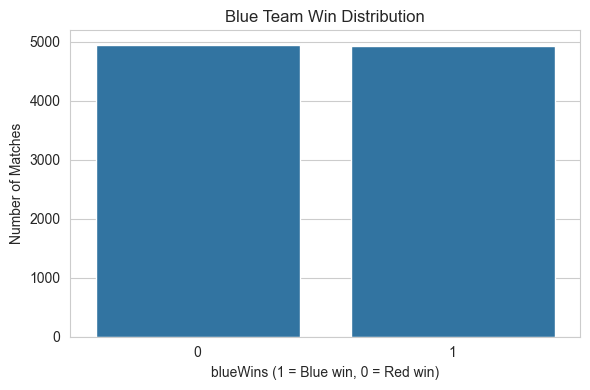

In [3]:
# Target distribution plot
# Visual confirmation of label balance (helps interpret accuracy/F1 and whether stratification matters).
plt.figure(figsize=(6, 4))
sns.countplot(x="blueWins", data=df)
plt.title("Blue Team Win Distribution")
plt.xlabel("blueWins (1 = Blue win, 0 = Red win)")
plt.ylabel("Number of Matches")
plt.tight_layout()
plt.show()


,blueDragons,blueHeralds,blueTowersDestroyed,redTowersDestroyed,redHeralds,redDragons
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.361980,0.187974,0.051422,0.043021,0.160036,0.413098
std,0.480597,0.390712,0.244369,0.216900,0.366658,0.492415
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,4.000000,2.000000,1.000000,1.000000


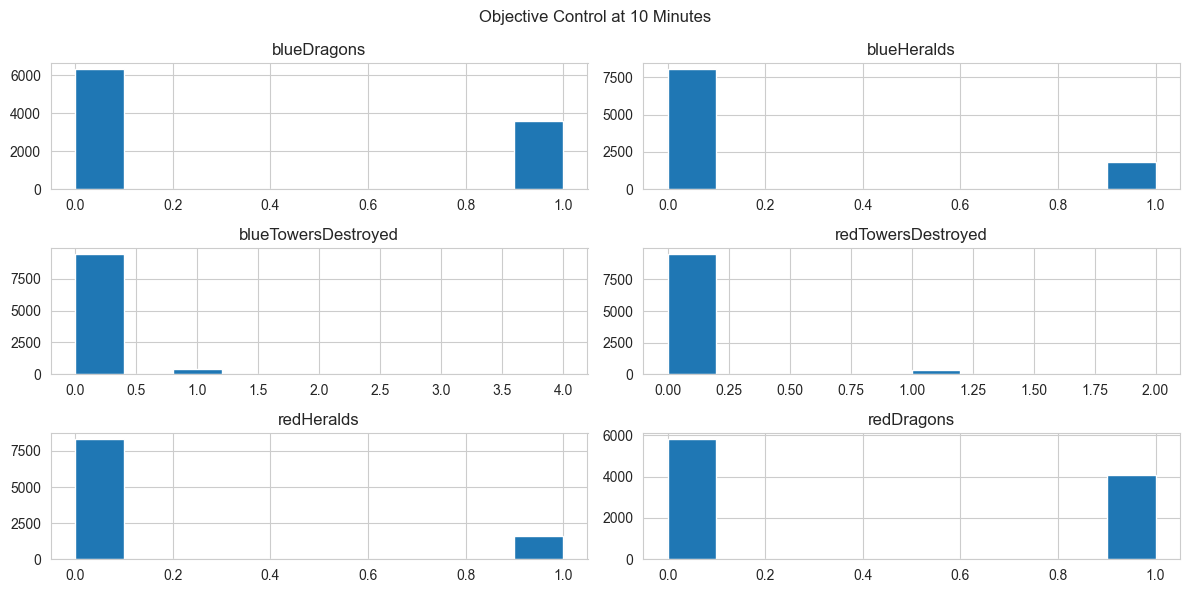

In [4]:
# Objective-control feasibility at 10 minutes (EDA)
# These features represent early objectives that *can* happen by 10 minutes,
# but should have low counts in many games (domain sanity check).
feasible_features = [
    "blueDragons",
    "blueHeralds",
    "blueTowersDestroyed",
    "redTowersDestroyed",
    "redHeralds",
    "redDragons",
]

# `describe()` shows count/mean/std/min/max. Here, we mainly want to confirm:
# - counts match dataset rows (no missing)
# - values look plausible for the 10-minute window
display(df[feasible_features].describe())

# Distributions help communicate how often early objectives occur
df[feasible_features].hist(bins=10, figsize=(12, 6))
plt.suptitle("Objective Control at 10 Minutes")
plt.tight_layout()
# Not saving this EDA plot to disk to keep the submission folder clean.
plt.show()


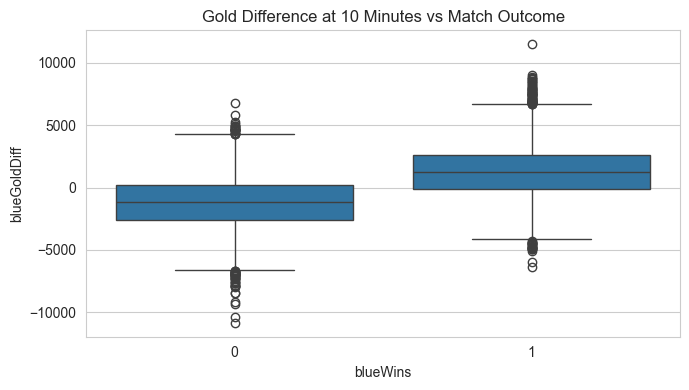

In [5]:
# Example economic signal (EDA): gold difference vs outcome
# Motivation: if early economy matters, we should see separation in gold difference
# between wins and losses even at 10 minutes.
plt.figure(figsize=(7, 4))
sns.boxplot(x="blueWins", y="blueGoldDiff", data=df)
plt.title("Gold Difference at 10 Minutes vs Match Outcome")
plt.xlabel("blueWins")
plt.ylabel("blueGoldDiff")
plt.tight_layout()
plt.show()


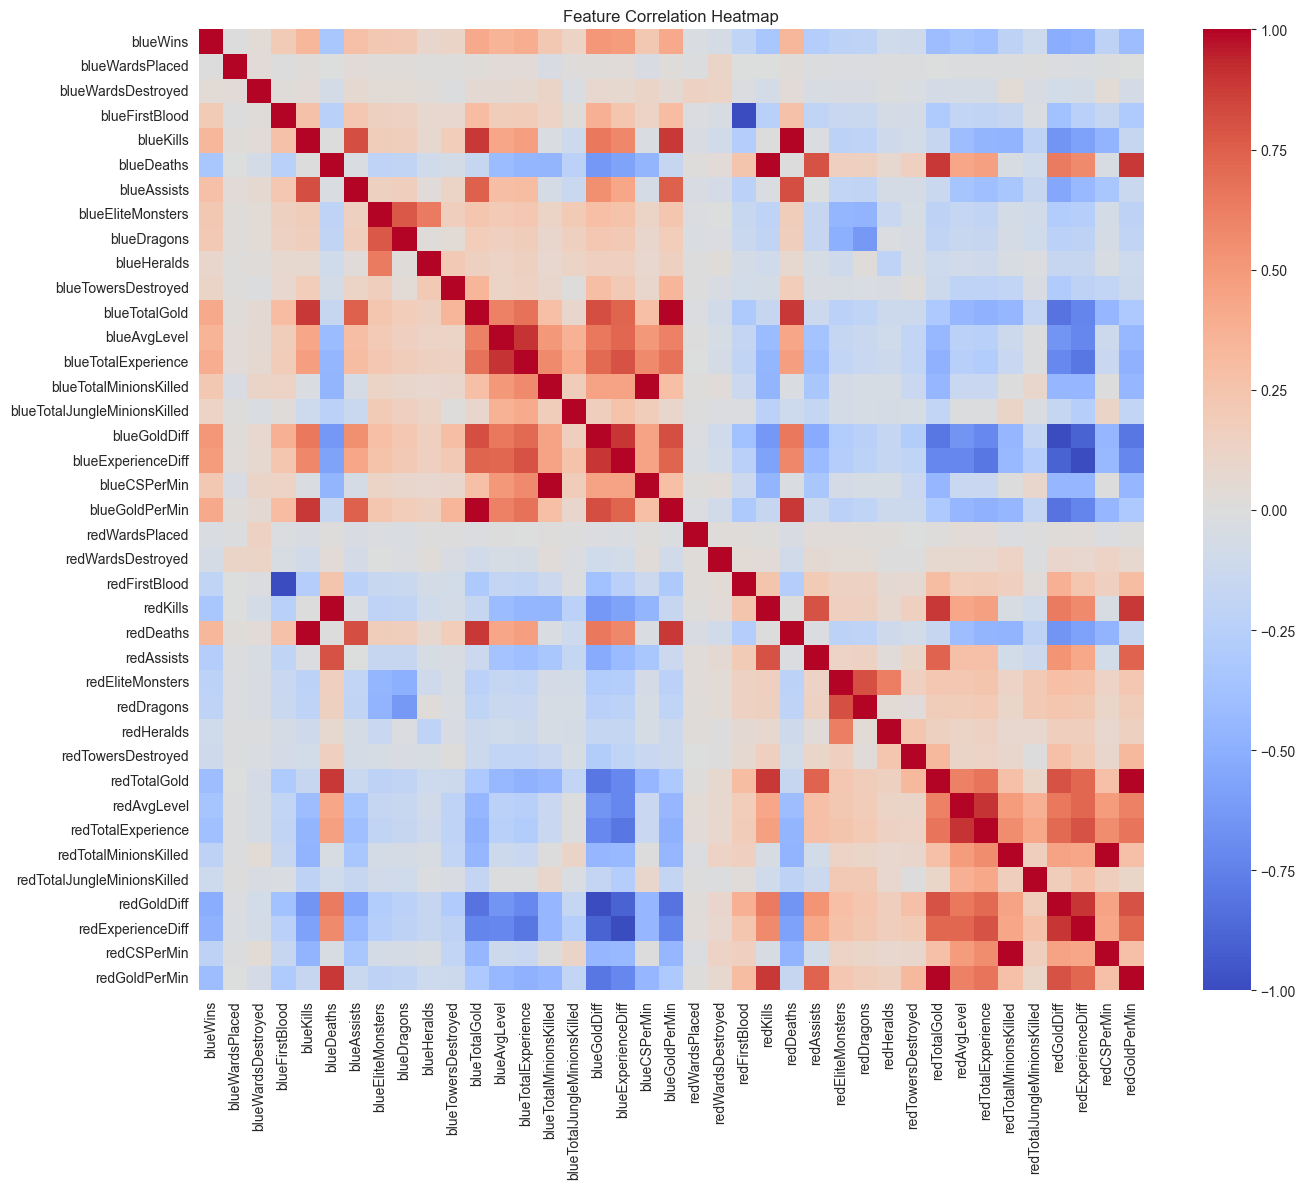

In [6]:
# Correlation heatmap (EDA)
# Correlation is descriptive/associative; it helps guide discussion but does not imply causality.
# We drop `gameId` because it's an identifier (including it would create meaningless correlations).
plt.figure(figsize=(14, 12))
sns.heatmap(df.drop(columns=["gameId"]).corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
# Not saving this EDA plot to disk to keep the submission folder clean.
plt.show()


## Preprocessing + Baseline

**Goal**: Prepare the data for modeling and establish a simple benchmark.

### Preprocessing Steps

1. **Feature/Target Separation**: 
   - Drop `gameId` (it's an identifier, not a predictive feature)
   - Separate features (X) from target (y)

2. **Train/Test Split**:
   - 80% training, 20% testing
   - **Stratification**: Preserves the win/loss ratio in both sets (important for balanced evaluation)
   - **Random state**: Ensures reproducibility

3. **Feature Scaling**:
   - **Why scale?** Some algorithms are sensitive to feature magnitudes:
     - **KNN**: Uses Euclidean distance → features with larger scales dominate
     - **Logistic Regression**: Uses gradient descent → convergence is faster with scaled features
   - **Random Forest**: Tree-based, doesn't need scaling (splits are based on thresholds, not distances)
   - **Important**: Fit the scaler ONLY on training data to prevent data leakage

### Baseline Model

**Logistic Regression** serves as our baseline because:
- It's simple and interpretable (coefficients show feature contributions)
- It's fast to train
- It provides a reasonable benchmark for comparison
- If more complex models don't beat it significantly, we know the problem might be feature-limited rather than model-limited


In [7]:
# Features/target separation
# X = predictive inputs (all numeric features except the label and identifier)
# y = label we want to predict (binary: 1 = Blue wins, 0 = Red wins)
# We drop:
# - "blueWins": this is our target, not a feature
# - "gameId": this is an identifier, not predictive (including it would be data leakage)
X = df.drop(["blueWins", "gameId"], axis=1)
y = df["blueWins"]

# Train/test split
# Why split? We need to evaluate models on unseen data to estimate real-world performance.
# - test_size=0.2: 20% for testing (common choice: 80/20 split)
# - random_state=42: Ensures reproducible results (same split every time we run)
# - stratify=y: CRITICAL - preserves the win/loss ratio in both train and test sets
#   Without stratification, we might get 60% wins in train and 40% in test, which would
#   make evaluation misleading. Stratification ensures both sets have similar class distributions.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

# Feature scaling
# Why scale? Different features have different units and scales:
# - Gold values might be in thousands (e.g., 15000)
# - Kill counts are small integers (e.g., 5)
# - Some algorithms are sensitive to these differences
#
# Which models need scaling?
# - KNN: Uses Euclidean distance → features with larger scales dominate the distance calculation
# - Logistic Regression: Uses gradient descent → convergence is faster and more stable with scaled features
# - Random Forest: Tree-based, makes splits based on thresholds → scale doesn't matter
#
# CRITICAL: Fit the scaler ONLY on training data to prevent data leakage
# If we fit on the full dataset (including test), we're "peeking" at test data statistics
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Learn mean/std from training data only
X_test_scaled = scaler.transform(X_test)        # Apply the same transformation to test data

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (7903, 38)
Test shape: (1976, 38)


Logistic Regression Baseline
Accuracy:  0.7161
F1-score:  0.7177
Precision: 0.7123
Recall:    0.7231
ROC-AUC:   0.8058


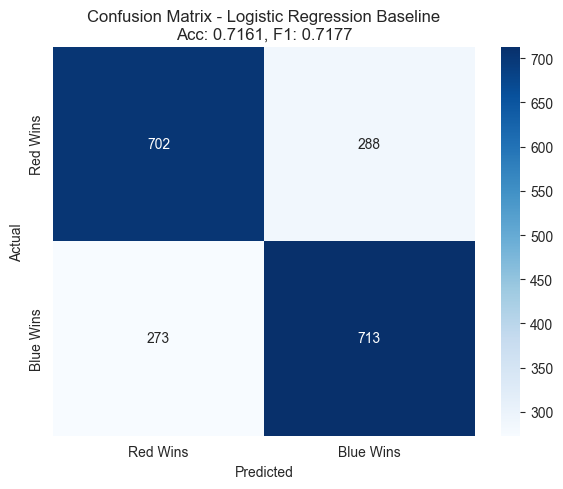


Classification report:
              precision    recall  f1-score   support

    Red Wins       0.72      0.71      0.71       990
   Blue Wins       0.71      0.72      0.72       986

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976



In [8]:
# Baseline (Phase 2): Logistic Regression (scaled features)
# Purpose: provide a simple, interpretable benchmark before comparing other models.
# Why Logistic Regression as baseline?
# - Simple linear model: easy to understand and explain
# - Fast to train: good for quick iterations
# - Interpretable: coefficients show feature contributions
# - If complex models don't beat it significantly, the problem might be feature-limited
# We train on scaled features because logistic regression uses gradient descent, which is scale-sensitive.
baseline = LogisticRegression(max_iter=2000, n_jobs=-1)  # max_iter: allow enough iterations to converge
baseline.fit(X_train_scaled, y_train)

# Predictions
# Two types of predictions:
# - `predict`: gives hard class labels (0 or 1) using a default threshold (usually 0.5)
# - `predict_proba`: gives probability scores (0.0 to 1.0) for each class
#   We take [:, 1] to get probabilities for the positive class (Blue wins)
# Probabilities are needed for ROC-AUC and ROC curves (threshold-independent metrics)
y_pred_base = baseline.predict(X_test_scaled)
y_proba_base = baseline.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
# We compute multiple metrics because each tells a different story:
# - Accuracy: Overall correctness = (TP + TN) / (TP + TN + FP + FN)
#   Simple but can be misleading if classes are imbalanced
# - F1-score: Harmonic mean of precision and recall = 2 × (precision × recall) / (precision + recall)
#   Our primary decision metric because it balances precision and recall
# - Precision: Of all positive predictions, how many were correct? = TP / (TP + FP)
#   "When we predict Blue wins, how often are we right?"
# - Recall: Of all actual positives, how many did we catch? = TP / (TP + FN)
#   "Of all Blue wins, how many did we correctly identify?"
# - ROC-AUC: Area under the ROC curve (threshold-independent)
#   Measures how well the model ranks positive examples above negative examples
#   Range: 0.5 (random) to 1.0 (perfect)
acc_base = accuracy_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base)
precision_base = precision_score(y_test, y_pred_base)
recall_base = recall_score(y_test, y_pred_base)
cm_base = confusion_matrix(y_test, y_pred_base)  # 2x2 matrix: [TN, FP; FN, TP]
roc_auc_base = roc_auc_score(y_test, y_proba_base)

print("Logistic Regression Baseline")
print(f"Accuracy:  {acc_base:.4f}")
print(f"F1-score:  {f1_base:.4f}")
print(f"Precision: {precision_base:.4f}")
print(f"Recall:    {recall_base:.4f}")
print(f"ROC-AUC:   {roc_auc_base:.4f}")

# Confusion matrix
# Rows = actual class, columns = predicted class
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_base,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Red Wins", "Blue Wins"],
    yticklabels=["Red Wins", "Blue Wins"],
)
plt.title(f"Confusion Matrix - Logistic Regression Baseline\nAcc: {acc_base:.4f}, F1: {f1_base:.4f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Full per-class breakdown (precision/recall/F1)
print("\nClassification report:")
print(classification_report(y_test, y_pred_base, target_names=["Red Wins", "Blue Wins"]))


## Engine (Final Model Comparison)

**Goal**: Compare multiple candidate models and select the best one using a defensible, reproducible decision rule.

### Models Compared

1. **Logistic Regression (Baseline)**: Linear model, interpretable, fast
2. **KNN (K-Nearest Neighbors)**: Instance-based, non-parametric, can capture non-linear patterns
3. **Random Forest**: Ensemble of decision trees, strong for tabular data, handles non-linearities and interactions

### Evaluation Metrics

We evaluate models using multiple metrics because each tells a different story:

- **Accuracy**: Overall correctness (correct predictions / total predictions)
  - **Limitation**: Can be misleading if classes are imbalanced
  
- **F1-Score**: Harmonic mean of precision and recall
  - **Why we use it as primary**: Balances false positives and false negatives
  - **Formula**: F1 = 2 × (precision × recall) / (precision + recall)
  - **When it's useful**: When both precision and recall matter equally
  
- **Precision**: Of all positive predictions, how many were correct? (TP / (TP + FP))
- **Recall**: Of all actual positives, how many did we catch? (TP / (TP + FN))
- **ROC-AUC**: Area under the ROC curve
  - **What it measures**: How well the model ranks positive examples above negative examples
  - **Why it's useful**: Threshold-independent (doesn't depend on the decision threshold)

### Selection Rule

**Primary**: Highest F1-score (best balance of precision/recall)  
**Tie-breaker**: Highest accuracy

This rule is defensible because:
- F1-score is robust to class imbalance
- It penalizes models that are too conservative or too aggressive
- Accuracy as a tie-breaker ensures we don't sacrifice overall correctness


In [9]:
# Model 1: KNN (scaled features)
# KNN uses distances between points, so scaling is required.
# `n_neighbors=5` is a simple baseline choice (not hyperparameter-tuned here).
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Predictions on scaled test set
y_pred_knn = knn.predict(X_test_scaled)
y_proba_knn = knn.predict_proba(X_test_scaled)[:, 1]

# Metrics (same set as baseline for apples-to-apples comparison)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
cm_knn = confusion_matrix(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, y_proba_knn)

print("KNN Results")
print(f"Accuracy:  {accuracy_knn:.4f}")
print(f"F1-score:  {f1_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall:    {recall_knn:.4f}")
print(f"ROC-AUC:   {roc_auc_knn:.4f}")


KNN Results
Accuracy:  0.6908
F1-score:  0.6919
Precision: 0.6881
Recall:    0.6957
ROC-AUC:   0.7516


In [10]:
# Model 2: Random Forest (unscaled features)
# Random Forest is a strong, non-linear baseline for tabular data.
# It is tree-based, so feature scaling is not required.
rf = RandomForestClassifier(
    n_estimators=100,        # number of trees
    max_depth=10,            # controls complexity / overfitting
    min_samples_split=5,     # minimum samples to split an internal node
    min_samples_leaf=2,      # minimum samples in a leaf
    random_state=42,         # reproducibility
    n_jobs=-1,               # use all CPU cores
)
rf.fit(X_train, y_train)

# Predictions on unscaled test set
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

print("Random Forest Results")
print(f"Accuracy:  {accuracy_rf:.4f}")
print(f"F1-score:  {f1_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall:    {recall_rf:.4f}")
print(f"ROC-AUC:   {roc_auc_rf:.4f}")


Random Forest Results
Accuracy:  0.7222
F1-score:  0.7209
Precision: 0.7227
Recall:    0.7191
ROC-AUC:   0.8037


In [11]:
# Compare models (engine dashboard table)
# Goal: put all model metrics into one table for easy comparison (and saving to CSV later).
model_cols = ["LogReg Baseline", "KNN", "Random Forest"]

comparison_df = pd.DataFrame(
    {
        "Metric": ["Accuracy", "F1-Score", "Precision", "Recall", "ROC-AUC"],
        "LogReg Baseline": [acc_base, f1_base, precision_base, recall_base, roc_auc_base],
        "KNN": [accuracy_knn, f1_knn, precision_knn, recall_knn, roc_auc_knn],
        "Random Forest": [accuracy_rf, f1_rf, precision_rf, recall_rf, roc_auc_rf],
    }
)

# Per-metric best model (helpful for slides: “which model wins on each metric?”)
comparison_df["Winner"] = comparison_df[model_cols].idxmax(axis=1)
comparison_df["Best_Score"] = comparison_df[model_cols].max(axis=1)

display(comparison_df)

# Winner decision rule (defense-ready)
# Why F1? It balances precision and recall, instead of optimizing only overall correctness.
# Tie-breaker: if F1 is equal, pick the higher accuracy.
decision_rule = "Highest F1-score wins (Accuracy used only as tie-breaker)"

# Put metrics in a dictionary so we can rank models cleanly
models = {
    "LogReg Baseline": {
        "accuracy": acc_base,
        "f1": f1_base,
        "precision": precision_base,
        "recall": recall_base,
        "roc_auc": roc_auc_base,
    },
    "KNN": {
        "accuracy": accuracy_knn,
        "f1": f1_knn,
        "precision": precision_knn,
        "recall": recall_knn,
        "roc_auc": roc_auc_knn,
    },
    "Random Forest": {
        "accuracy": accuracy_rf,
        "f1": f1_rf,
        "precision": precision_rf,
        "recall": recall_rf,
        "roc_auc": roc_auc_rf,
    },
}

# Select winner by (F1, Accuracy)
winner = max(models.keys(), key=lambda m: (models[m]["f1"], models[m]["accuracy"]))

# Runner-up for a simple side-by-side print
ranked = sorted(models.keys(), key=lambda m: (models[m]["f1"], models[m]["accuracy"]), reverse=True)
runner_up = ranked[1]

winner_metrics = models[winner]
loser = runner_up
loser_metrics = models[runner_up]

print(f"Winner: {winner}")
print(f"Decision rule: {decision_rule}")
print(f"F1: {winner_metrics['f1']:.4f} vs {loser_metrics['f1']:.4f}")
print(f"Accuracy: {winner_metrics['accuracy']:.4f} vs {loser_metrics['accuracy']:.4f}")
print(f"ROC-AUC: {winner_metrics['roc_auc']:.4f} vs {loser_metrics['roc_auc']:.4f}")


,Metric,LogReg Baseline,KNN,Random Forest,Winner,Best_Score
0,Accuracy,0.716093,0.690789,0.722166,Random Forest,0.722166
1,F1-Score,0.717665,0.691881,0.720895,Random Forest,0.720895
2,Precision,0.712288,0.688064,0.722732,Random Forest,0.722732
3,Recall,0.723124,0.695740,0.719067,LogReg Baseline,0.723124
4,ROC-AUC,0.805762,0.751597,0.803710,LogReg Baseline,0.805762


Winner: Random Forest
Decision rule: Highest F1-score wins (Accuracy used only as tie-breaker)
F1: 0.7209 vs 0.7177
Accuracy: 0.7222 vs 0.7161
ROC-AUC: 0.8037 vs 0.8058


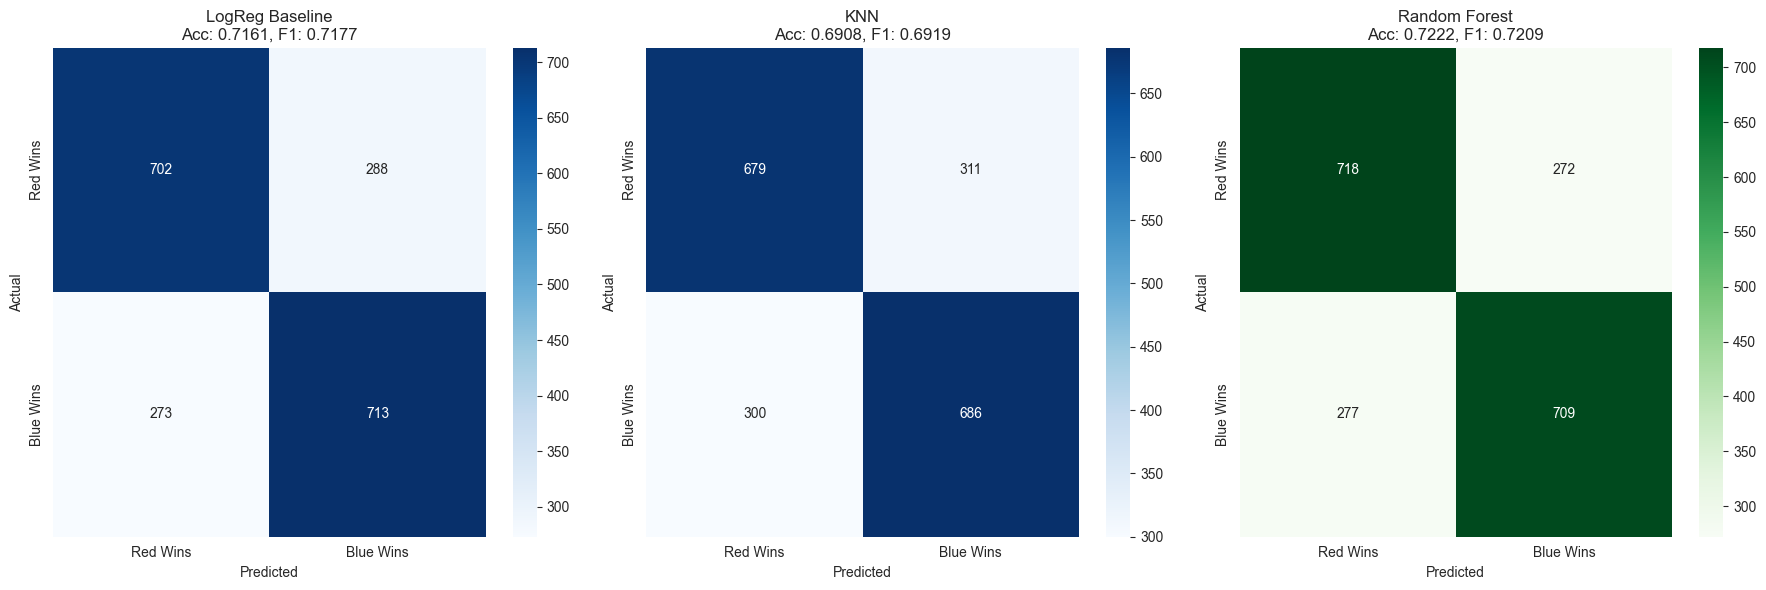

In [ ]:
# Confusion matrices (required) + save
# Confusion matrices show *where* the models make mistakes (FP vs FN), not just a single score.
# We plot all 3 side-by-side for easy comparison.
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(
    cm_base,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=axes[0],
    xticklabels=["Red Wins", "Blue Wins"],
    yticklabels=["Red Wins", "Blue Wins"],
)
axes[0].set_title(f"LogReg Baseline\nAcc: {acc_base:.4f}, F1: {f1_base:.4f}")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(
    cm_knn,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=axes[1],
    xticklabels=["Red Wins", "Blue Wins"],
    yticklabels=["Red Wins", "Blue Wins"],
)
axes[1].set_title(f"KNN\nAcc: {accuracy_knn:.4f}, F1: {f1_knn:.4f}")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Greens",
    ax=axes[2],
    xticklabels=["Red Wins", "Blue Wins"],
    yticklabels=["Red Wins", "Blue Wins"],
)
axes[2].set_title(f"Random Forest\nAcc: {accuracy_rf:.4f}, F1: {f1_rf:.4f}")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")

plt.tight_layout()
# Saved image is part of the deliverables
plt.savefig("Confusion_Matrices.png", dpi=300, bbox_inches="tight")
plt.show()


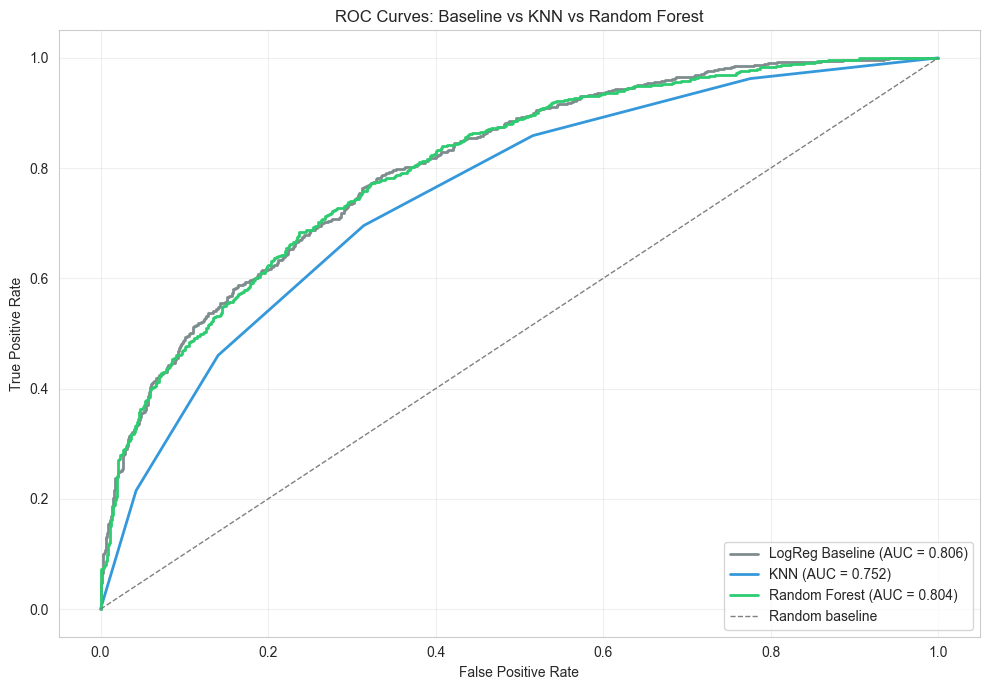

In [ ]:
# ROC curves (added) + save
# ROC curves show TPR vs FPR across all thresholds.
# AUC summarizes this curve: higher = better ranking of positives above negatives.
fpr_base, tpr_base, _ = roc_curve(y_test, y_proba_base)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(10, 7))
plt.plot(
    fpr_base,
    tpr_base,
    label=f"LogReg Baseline (AUC = {roc_auc_base:.3f})",
    linewidth=2,
    color="#7f8c8d",
)
plt.plot(
    fpr_knn,
    tpr_knn,
    label=f"KNN (AUC = {roc_auc_knn:.3f})",
    linewidth=2,
    color="#3498db",
)
plt.plot(
    fpr_rf,
    tpr_rf,
    label=f"Random Forest (AUC = {roc_auc_rf:.3f})",
    linewidth=2,
    color="#2ecc71",
)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1, label="Random baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Baseline vs KNN vs Random Forest")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
# Saved image is part of the deliverables
plt.savefig("ROC_Curves.png", dpi=300, bbox_inches="tight")
plt.show()


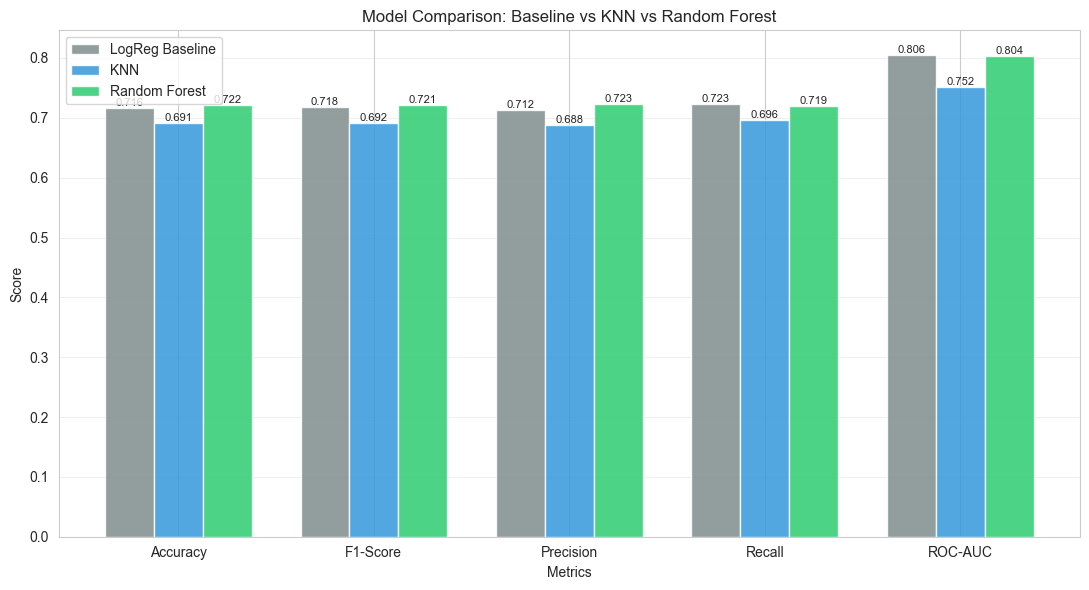

In [ ]:
# Metric comparison bar chart + save (3 models)
# One chart that compares the 3 models across all metrics.
# This is useful for a presentation slide (quick visual comparison).
fig, ax = plt.subplots(figsize=(11, 6))

x = np.arange(len(comparison_df))
width = 0.25

bars0 = ax.bar(
    x - width,
    comparison_df["LogReg Baseline"],
    width,
    label="LogReg Baseline",
    alpha=0.85,
    color="#7f8c8d",
)
bars1 = ax.bar(x, comparison_df["KNN"], width, label="KNN", alpha=0.85, color="#3498db")
bars2 = ax.bar(
    x + width,
    comparison_df["Random Forest"],
    width,
    label="Random Forest",
    alpha=0.85,
    color="#2ecc71",
)

ax.set_xlabel("Metrics")
ax.set_ylabel("Score")
ax.set_title("Model Comparison: Baseline vs KNN vs Random Forest")
ax.set_xticks(x)
ax.set_xticklabels(comparison_df["Metric"])
ax.legend()
ax.grid(axis="y", alpha=0.3)

# Label bars with values for readability
for bars in (bars0, bars1, bars2):
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, h, f"{h:.3f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
# Saved image is part of the deliverables
plt.savefig("Metric_Comparison.png", dpi=300, bbox_inches="tight")
plt.show()


Random Forest feature importances (ALL features):


,Feature,Importance
15,blueGoldDiff,0.135692
34,redGoldDiff,0.122755
16,blueExperienceDiff,0.105691
35,redExperienceDiff,0.080281
18,blueGoldPerMin,0.051375
29,redTotalGold,0.044681
37,redGoldPerMin,0.043533
10,blueTotalGold,0.043428
31,redTotalExperience,0.037203
12,blueTotalExperience,0.032669


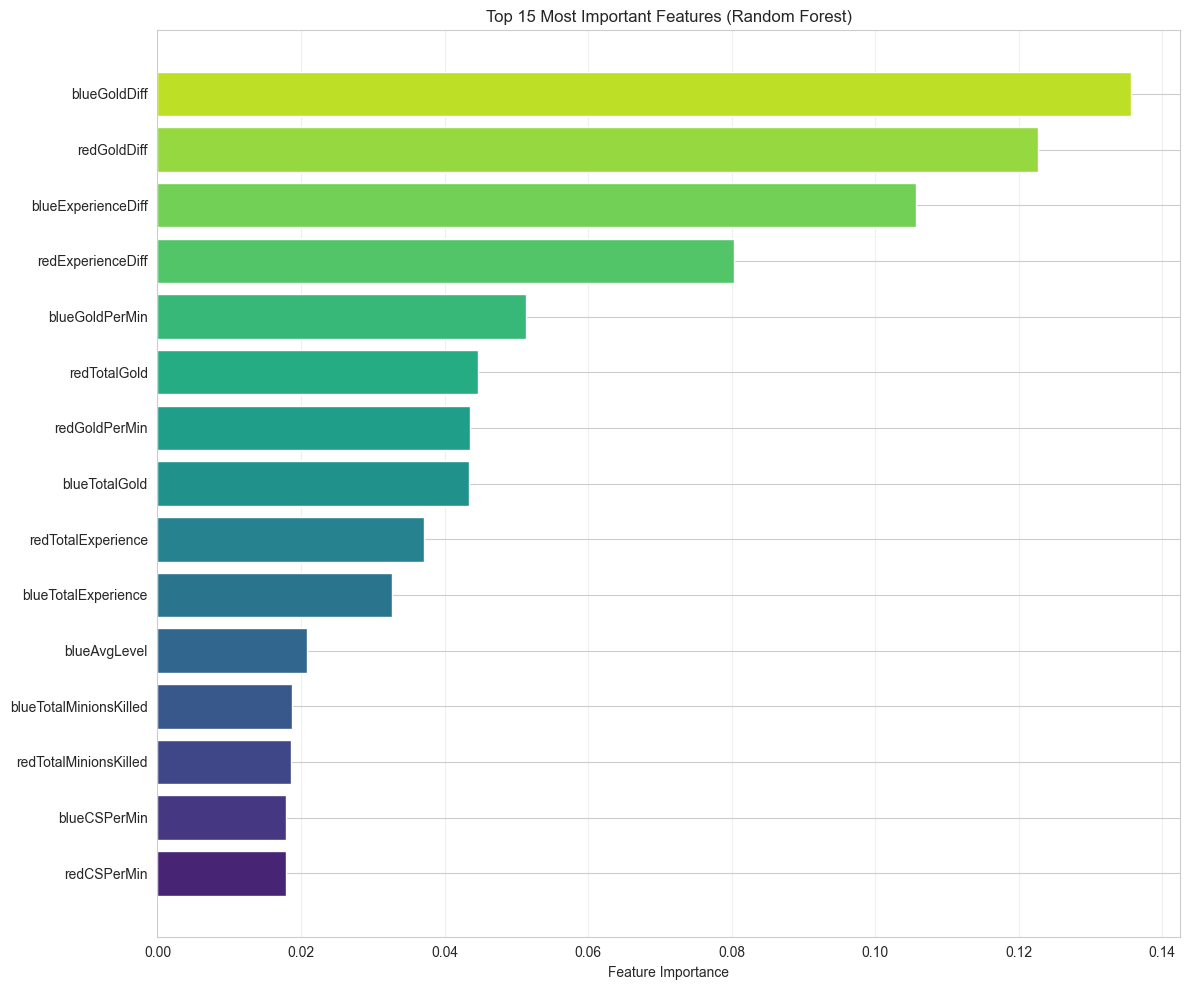

In [ ]:
# Feature importance (Random Forest built-in)
# Random Forest provides built-in feature importance via `feature_importances_`
# How it works:
# - Measures how much each feature reduces impurity (Gini or entropy) across all trees
# - Features that appear in splits near the root (affecting many samples) get higher importance
# - Features that consistently help separate classes get higher importance
#
# Advantages:
# - Fast (computed during training)
# - No need to retrain or shuffle features
# - Useful for quick intuition
#
# Limitations:
# - Can be biased toward features with many categories or high cardinality
# - Can be biased toward features with larger scales (though less so than some methods)
# - Only works for tree-based models
# - Measures model internals, not necessarily predictive contribution
#
# We'll compare this with permutation importance (model-agnostic) later to get a more robust view.
feature_importance = (
    pd.DataFrame(
        {
            "Feature": X.columns,
            "Importance": rf.feature_importances_,
        }
    )
    .sort_values("Importance", ascending=False)
)

# Save full table as a deliverable
feature_importance.to_csv("Feature_Importance.csv", index=False)

print("Random Forest feature importances (ALL features):")
# Show every feature (38 rows)
display(feature_importance)

# Plot top 15 for readability (kept as a deliverable image)
plot_df = feature_importance.head(15).iloc[::-1]
plt.figure(figsize=(12, 10))
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(plot_df)))
plt.barh(plot_df["Feature"], plot_df["Importance"], color=colors)
plt.xlabel("Feature Importance")
plt.title("Top 15 Most Important Features (Random Forest)")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.savefig("Feature_Importance.png", dpi=300, bbox_inches="tight")
plt.show()


Permutation Importance (ALL features) - Winning Model: Random Forest


,Feature,Importance_Mean,Importance_Std
34,redGoldDiff,0.010926,0.003902
15,blueGoldDiff,0.007930,0.003774
37,redGoldPerMin,0.006287,0.002591
18,blueGoldPerMin,0.004318,0.002420
35,redExperienceDiff,0.003829,0.002355
0,blueWardsPlaced,0.002908,0.001355
7,blueDragons,0.002785,0.002486
17,blueCSPerMin,0.002220,0.001449
4,blueDeaths,0.001920,0.001466
16,blueExperienceDiff,0.001879,0.004504


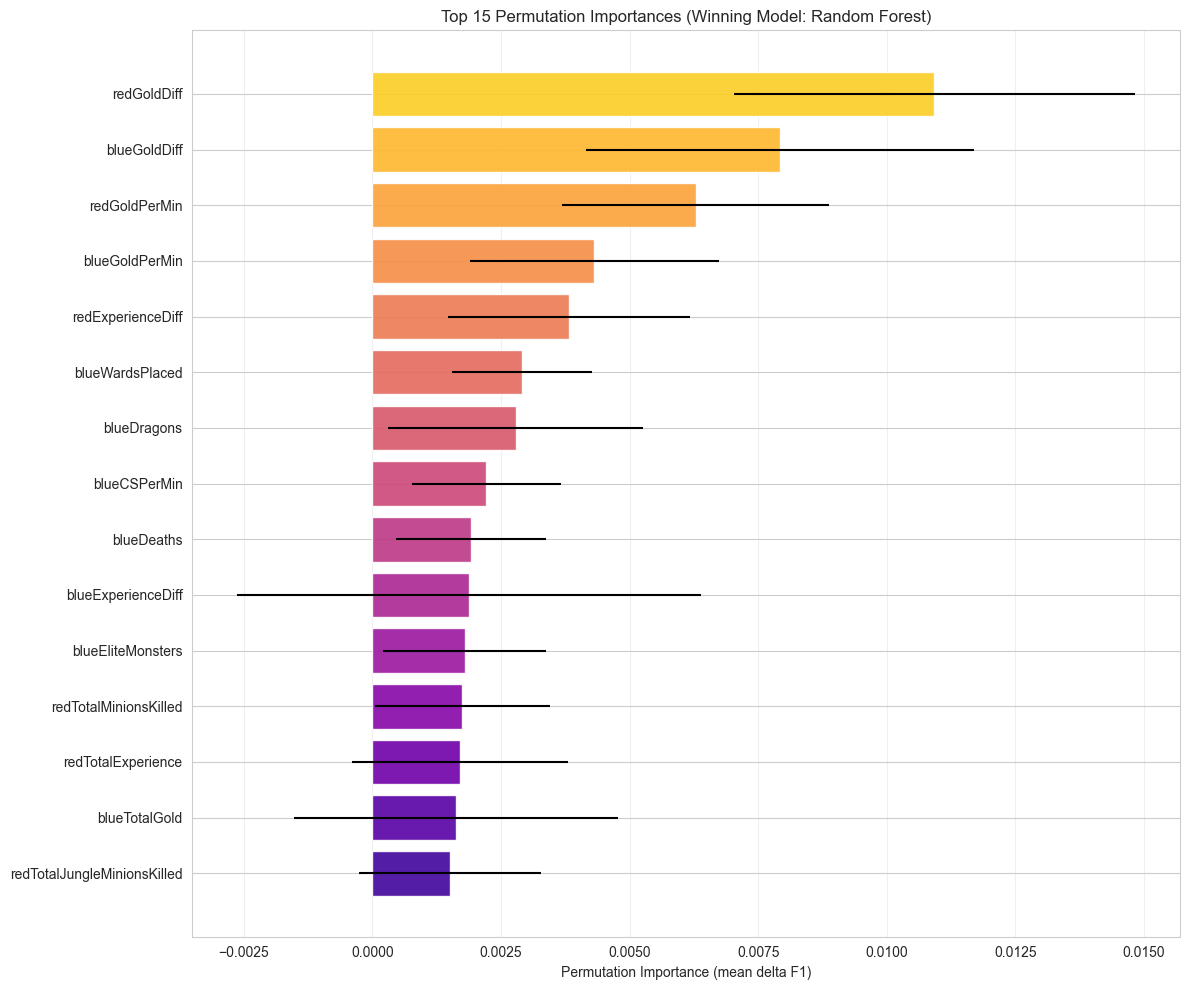

In [ ]:
# Permutation importance (model-agnostic) on the winning model (scoring = F1)
# Permutation importance answers: “how much does the model's F1 drop if we destroy the
# relationship between a feature and the target by shuffling that feature?”
# This measures predictive association (not causation).
feature_names = X.columns.tolist()

# Important: use the feature representation that matches how the winning model was trained.
# - Random Forest: unscaled pandas DataFrame
# - KNN / Logistic Regression: scaled numeric features
if winner == "Random Forest":
    perm_model = rf
    X_perm = X_test.copy()  # unscaled for RF
elif winner == "KNN":
    perm_model = knn
    X_perm = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)  # scaled for KNN
else:
    # LogReg baseline (and other linear models) use scaled features
    perm_model = baseline
    X_perm = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)

# Permutation importance computation
# - scoring="f1": We use F1-score as the performance metric (matches our selection criterion)
# - n_repeats=10: Repeat shuffling 10 times per feature to get stable estimates
#   Higher = more stable but slower. 10 is a good balance.
# - random_state=42: Ensures reproducibility (same shuffles every run)
# - n_jobs=-1: Use all CPU cores for parallel computation (faster)
perm = permutation_importance(
    perm_model,
    X_perm,
    y_test,
    scoring="f1",
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
)

perm_importance = (
    pd.DataFrame(
        {
            "Feature": feature_names,
            "Importance_Mean": perm.importances_mean,
            "Importance_Std": perm.importances_std,
        }
    )
    .sort_values("Importance_Mean", ascending=False)
)

# Save full table as a deliverable
perm_importance.to_csv("Permutation_Importance.csv", index=False)

print(f"Permutation Importance (ALL features) - Winning Model: {winner}")
# Show every feature (38 rows)
display(perm_importance)

# Plot top 15 for readability (kept as a deliverable image)
plot_df = perm_importance.head(15).iloc[::-1]
plt.figure(figsize=(12, 10))
plt.barh(
    plot_df["Feature"],
    plot_df["Importance_Mean"],
    xerr=plot_df["Importance_Std"],
    color=plt.cm.plasma(np.linspace(0.1, 0.9, len(plot_df))),
    alpha=0.9,
)
plt.xlabel("Permutation Importance (mean delta F1)")
plt.title(f"Top 15 Permutation Importances (Winning Model: {winner})")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.savefig("Permutation_Importance.png", dpi=300, bbox_inches="tight")
plt.show()


## Dashboard – Final Summary (Winner + Insights)


This section consolidates:
- **Winner identification**: Which model won and why (according to our decision rule)
- **Performance summary**: Key metrics (Accuracy, F1, ROC-AUC) for the winning model
- **Feature insights**: What signals the model is using to make predictions
- **Business/Game takeaways**: What this means for players, coaches, or game designers

> **Note**: For a detailed game strategy analysis of which features matter for winning games (combining model results with League of Legends game knowledge), see the section "What Features Are Important for Winning Games?" below.

**Interpretation guidelines**:
- We use **non-causal language**: "predictive signals" and "associations" rather than "causes"
- Feature importance tells us what the model relies on, not what directly causes wins
- These insights are based on correlation, not controlled experiments

**How to read the results**:
- High importance features = the model uses these heavily for predictions
- Low importance features = the model can make good predictions without them (possibly redundant with other features)
- The actual importance values (permutation importance) show how much performance drops when that feature is shuffled

> **Note**: For a detailed game strategy analysis of which features matter for winning games (combining model results with League of Legends game knowledge), see the section "What Features Are Important for Winning Games?" below.


In [ ]:
# Save final artifacts (requested)
# This cell writes the key tables to disk so they can be submitted/attached to a report.

# 1) Full metric comparison table
comparison_df.to_csv("Model_Comparison.csv", index=False)

# 2) Compact summary table (plus winner and decision rule)
results_summary = {
    "Model": ["LogReg Baseline", "KNN", "Random Forest", f"Winner ({winner} by F1)"],
    "Accuracy": [acc_base, accuracy_knn, accuracy_rf, winner_metrics["accuracy"]],
    "F1_Score": [f1_base, f1_knn, f1_rf, winner_metrics["f1"]],
    "Precision": [precision_base, precision_knn, precision_rf, winner_metrics["precision"]],
    "Recall": [recall_base, recall_knn, recall_rf, winner_metrics["recall"]],
    "ROC_AUC": [roc_auc_base, roc_auc_knn, roc_auc_rf, winner_metrics["roc_auc"]],
    "Decision_Rule": ["", "", "", decision_rule],
}
results_df = pd.DataFrame(results_summary)
results_df.to_csv("Results_Summary.csv", index=False)

# Confirm deliverables were saved
print("Saved CSVs:")
print("- Model_Comparison.csv")
print("- Feature_Importance.csv")
print("- Permutation_Importance.csv")
print("- Results_Summary.csv")

# “Dashboard” printout: winner + key metrics
print("\nWINNER (by F1):", winner)
print("Decision rule:", decision_rule)
print(f"Accuracy: {winner_metrics['accuracy']*100:.2f}%")
print(f"F1-score: {winner_metrics['f1']:.4f}")
print(f"ROC-AUC:  {winner_metrics['roc_auc']:.4f}")

# Quick examples of top signals (for talking points)
print("\nMost predictive signals (examples):")
print("- Random Forest built-in importance (top 5):")
for _, r in feature_importance.head(5).iterrows():
    print(f"  - {r['Feature']}: {r['Importance']:.4f}")

print("- Permutation importance on winning model (top 5):")
for _, r in perm_importance.head(5).iterrows():
    print(f"  - {r['Feature']}: {r['Importance_Mean']:.4f} +/- {r['Importance_Std']:.4f}")

# Defense-friendly interpretation (keep language non-causal)
print("\nGame / business takeaways:")
print("- Early economy + tempo signals (gold/XP differences and rates) are strong predictors at 10 minutes.")
print("- Objectives matter, but their predictive strength is typically lower than gold/XP in this dataset.")
print("- Player strategy: prioritize consistent early gold/XP generation; avoid high-variance fights when behind.")
print("- Balance strategy: if snowballing is an issue, consider tuning early gold/XP sources and objective rewards.")

print("\nReminder: importance = association/predictive power, not causation.")


Saved CSVs:
- Phase3_Model_Comparison.csv
- Phase3_Feature_Importance.csv
- Phase3_Permutation_Importance.csv
- Phase3_Results_Summary.csv

WINNER (by F1): Random Forest
Decision rule: Highest F1-score wins (Accuracy used only as tie-breaker)
Accuracy: 72.22%
F1-score: 0.7209
ROC-AUC:  0.8037

Most predictive signals (examples):
- Random Forest built-in importance (top 5):
  - blueGoldDiff: 0.1357
  - redGoldDiff: 0.1228
  - blueExperienceDiff: 0.1057
  - redExperienceDiff: 0.0803
  - blueGoldPerMin: 0.0514
- Permutation importance on winning model (top 5):
  - redGoldDiff: 0.0109 +/- 0.0039
  - blueGoldDiff: 0.0079 +/- 0.0038
  - redGoldPerMin: 0.0063 +/- 0.0026
  - blueGoldPerMin: 0.0043 +/- 0.0024
  - redExperienceDiff: 0.0038 +/- 0.0024

Game / business takeaways:
- Early economy + tempo signals (gold/XP differences and rates) are strong predictors at 10 minutes.
- Objectives matter, but their predictive strength is typically lower than gold/XP in this dataset.
- Player strategy: p

## What Features Are Important for Winning Games? (Game Strategy Perspective)

**Important distinction**: This section discusses what features are important **for winning games** from a gameplay/strategy perspective, which is different from what's important **for the model's predictions**.

### Understanding the Two Perspectives

1. **Model Predictive Importance** (what we measured above):
   - "Which features help the model predict outcomes accurately?"
   - Measured by permutation importance (how much performance drops when shuffled)
   - Can be affected by feature redundancy, correlations, and model architecture

2. **Game Strategy Importance** (what we discuss here):
   - "Which features represent game mechanics that actually matter for winning?"
   - Based on League of Legends game design and competitive strategy
   - What players, coaches, and analysts focus on

### Why They Might Differ

- **Redundancy**: If `blueGoldDiff` and `blueTotalGold` are highly correlated, the model might only need one. But both represent important game concepts.
- **Timing**: Some features might be predictive at 10 minutes but not directly causal (they're early indicators of later advantages).
- **Model limitations**: The model learns patterns from data, but game knowledge tells us what mechanics actually drive wins.

The following analysis combines **model results** with **game domain knowledge** to identify what truly matters for winning.


In [18]:
# Analyze what features are important for winning games (game strategy perspective)
# This combines model results with League of Legends game knowledge

print("=" * 90)
print("FEATURES IMPORTANT FOR WINNING GAMES (Game Strategy Analysis)")
print("=" * 90)

# Get top features from permutation importance (most predictive)
top_features = perm_importance.head(10).copy()

print("\n📊 TOP 10 MOST PREDICTIVE FEATURES (from model perspective):")
print("-" * 90)
for idx, row in top_features.iterrows():
    print(f"{row['Feature']:35s} | Importance: {row['Importance_Mean']:8.6f} ± {row['Importance_Std']:.6f}")

print("\n" + "=" * 90)
print("🎮 GAME STRATEGY INTERPRETATION: Why These Features Matter for Winning")
print("=" * 90)

# Categorize features by game mechanics and explain their importance
feature_categories = {
    "Economy (Gold)": {
        "features": ["redGoldDiff", "blueGoldDiff", "redGoldPerMin", "blueGoldPerMin", "redTotalGold", "blueTotalGold"],
        "explanation": """
        **Why Gold Matters for Winning:**
        - Gold = purchasing power for items (weapons, armor, consumables)
        - Items provide stats (damage, defense, abilities) that directly impact combat effectiveness
        - Gold advantage at 10 minutes often snowballs: more items → win fights → more objectives → more gold
        - Gold per minute (GPM) shows economic efficiency and farming consistency
        - Gold difference is the most direct measure of economic advantage
        
        **Game Strategy Insight:**
        - Prioritize consistent gold generation (last-hitting minions, jungle camps)
        - Avoid risky fights when behind in gold (you're at a stat disadvantage)
        - Gold leads compound: use them to secure objectives and extend the advantage
        """,
    },
    "Experience (XP)": {
        "features": ["redExperienceDiff", "blueExperienceDiff", "redAvgLevel", "blueAvgLevel", "redTotalExperience", "blueTotalExperience"],
        "explanation": """
        **Why Experience Matters for Winning:**
        - Experience → levels → stat increases (health, damage, defense) + ability upgrades
        - Level advantages = stronger champions in combat
        - Experience difference shows which team is ahead in progression
        - Average level reflects team-wide power level
        
        **Game Strategy Insight:**
        - Don't fall behind in XP: share experience in lanes, don't miss minion waves
        - XP leads enable you to win fights and secure objectives
        - Early XP advantages compound: higher level → win fights → deny enemy XP → bigger lead
        """,
    },
    "Objectives": {
        "features": ["blueDragons", "redDragons", "blueHeralds", "redHeralds", "blueTowersDestroyed", "redTowersDestroyed"],
        "explanation": """
        **Why Objectives Matter for Winning:**
        - Dragons: Provide permanent team-wide stat bonuses (stacking buffs)
        - Rift Herald: Can destroy towers, creating map pressure and gold
        - Towers: Provide gold, map control, and vision denial
        - Objectives create advantages that persist throughout the game
        
        **Game Strategy Insight:**
        - At 10 minutes, objectives are limited but impactful
        - First dragon/herald often goes to the team with early gold/XP lead
        - Tower destruction opens up the map and creates pressure
        - Objective control is both a cause and effect of being ahead
        """,
    },
    "Combat Stats": {
        "features": ["blueKills", "redKills", "blueDeaths", "redDeaths", "blueAssists", "redAssists", "blueFirstBlood", "redFirstBlood"],
        "explanation": """
        **Why Combat Stats Matter for Winning:**
        - Kills: Provide gold bounties and temporary numerical advantage (5v4 fights)
        - Deaths: Give gold to enemies and create windows for objectives
        - Assists: Share gold/XP and show team coordination
        - First Blood: Early gold advantage that can snowball
        
        **Game Strategy Insight:**
        - Kills are both cause and effect: ahead teams get more kills, kills create advantages
        - Avoid unnecessary deaths: they give gold and create opportunities for enemies
        - Team coordination (assists) shows better macro play
        - First blood often indicates which team has better early game execution
        """,
    },
    "Vision & Map Control": {
        "features": ["blueWardsPlaced", "redWardsPlaced", "blueWardsDestroyed", "redWardsDestroyed"],
        "explanation": """
        **Why Vision Matters for Winning:**
        - Wards provide information about enemy positions
        - Vision control enables safe objective takes and prevents ganks
        - Destroying enemy wards denies their information
        - Vision is a form of map control
        
        **Game Strategy Insight:**
        - Teams ahead often have better vision (can ward deeper, deny enemy vision)
        - Vision enables objective control and prevents throws
        - Vision is both a luxury of being ahead and a tool to maintain leads
        """,
    },
    "Farming (CS)": {
        "features": ["blueCSPerMin", "redCSPerMin", "blueTotalMinionsKilled", "redTotalMinionsKilled", 
                    "blueTotalJungleMinionsKilled", "redTotalJungleMinionsKilled"],
        "explanation": """
        **Why Farming Matters for Winning:**
        - CS (Creep Score) = minions killed = gold and experience
        - CS per minute shows farming efficiency and consistency
        - Better farming = more gold/XP = item/level advantages
        - Jungle camps provide additional gold/XP beyond lane minions
        
        **Game Strategy Insight:**
        - Consistent farming is the foundation of gold/XP leads
        - CS per minute is a skill metric: better players farm more efficiently
        - Don't sacrifice too much CS for risky plays
        - Farming advantage compounds into combat and objective advantages
        """,
    },
}

# Analyze top features and explain their game significance
print("\n🔍 DETAILED ANALYSIS OF TOP FEATURES FOR WINNING GAMES:\n")

for category, info in feature_categories.items():
    # Find which top features belong to this category
    category_features = [f for f in top_features['Feature'].tolist() if f in info['features']]
    
    if category_features:
        print(f"\n{'='*90}")
        print(f"📌 {category.upper()}")
        print(f"{'='*90}")
        print(f"Top features in this category: {', '.join(category_features)}")
        print(info['explanation'])

# Summary: What's most important for winning games
print("\n" + "=" * 90)
print("🎯 SUMMARY: What's Most Important for Winning Games at 10 Minutes")
print("=" * 90)
print("""
Based on both model predictions and game design knowledge, here's what matters most:

1. **ECONOMY (Gold) - MOST CRITICAL**
   - Gold difference is the strongest predictor (redGoldDiff, blueGoldDiff)
   - Gold enables item purchases → stat advantages → combat wins
   - Gold per minute shows economic efficiency
   - Strategy: Prioritize consistent gold generation, use gold leads to secure advantages

2. **EXPERIENCE (XP) - VERY IMPORTANT**
   - Experience difference and average level show team progression
   - Level advantages = stat advantages = combat advantages
   - Strategy: Don't fall behind in XP, share experience efficiently

3. **OBJECTIVES - MODERATELY IMPORTANT**
   - Dragons, Heralds, and Towers provide persistent advantages
   - At 10 minutes, limited but impactful
   - Strategy: Secure objectives when ahead, deny when behind

4. **COMBAT STATS - CONTEXTUAL**
   - Kills/deaths are both cause and effect of being ahead
   - First blood provides early advantage
   - Strategy: Avoid unnecessary deaths, capitalize on numerical advantages

5. **FARMING (CS) - FOUNDATIONAL**
   - CS per minute shows farming efficiency
   - Better farming = more gold/XP = advantages
   - Strategy: Maintain consistent CS, don't sacrifice farming for risky plays

6. **VISION - SUPPORTIVE**
   - Enables safe plays and objective control
   - Both a luxury of being ahead and a tool to maintain leads
   - Strategy: Maintain vision control, deny enemy vision

**Key Takeaway**: Economy (gold) and experience are the foundation of early game advantages.
Teams that generate more gold and XP at 10 minutes are statistically more likely to win.
These advantages compound: gold/XP → items/levels → combat wins → objectives → more gold/XP.
""")


FEATURES IMPORTANT FOR WINNING GAMES (Game Strategy Analysis)

📊 TOP 10 MOST PREDICTIVE FEATURES (from model perspective):
------------------------------------------------------------------------------------------
redGoldDiff                         | Importance: 0.010926 ± 0.003902
blueGoldDiff                        | Importance: 0.007930 ± 0.003774
redGoldPerMin                       | Importance: 0.006287 ± 0.002591
blueGoldPerMin                      | Importance: 0.004318 ± 0.002420
redExperienceDiff                   | Importance: 0.003829 ± 0.002355
blueWardsPlaced                     | Importance: 0.002908 ± 0.001355
blueDragons                         | Importance: 0.002785 ± 0.002486
blueCSPerMin                        | Importance: 0.002220 ± 0.001449
blueDeaths                          | Importance: 0.001920 ± 0.001466
blueExperienceDiff                  | Importance: 0.001879 ± 0.004504

🎮 GAME STRATEGY INTERPRETATION: Why These Features Matter for Winning

🔍 DETAILED ANA

In [ ]:
# Folder cleanup (optional): remove non-essential EDA images to keep submission clean
# This is safe because we check existence before deleting.
# Note: The deliverable images are saved with names like `*.png` and are NOT removed.
import os

for fname in [
    "my_plot.png",
    "Objective Control at 10 Minutes.png",
]:
    if os.path.exists(fname):
        os.remove(fname)
        print(f"Removed: {fname}")

